## Analyze data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Forcasting

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from scipy.sparse import data
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor


# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
#     n_vars = 1 if type(data) is list else data.shape[1]
#     df = pd.DataFrame(data)
#     cols = list()
#     # input sequence (t-n, ... t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#     # print(cols)
#     # forecast sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#     # put it all together
#     agg = pd.concat(cols, axis=1)
#     # drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)

#     return agg.values


def get_training_model(X_train, y_train, model="dtree", svm_kernel="rbf", params=None, col_features=None):
    result = None
    if model == "Catboost":
        result= CatBoostRegressor(iterations=2,
                          learning_rate=0.1,
                          depth=2)
        result.fit(X_train, y_train)
    if model == "dtree":
        result = DecisionTreeRegressor(
            max_depth=8)
        result.fit(X_train, y_train)
    elif model == "random_forest":
        result = RandomForestRegressor(
            n_estimators=1000, oob_score=True, max_depth=8)
        result.fit(X_train, y_train)
    elif model == "svm":
        result = svm.SVR(kernel="linear")
        #  {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}
        result.fit(X_train, y_train)
    elif model == "xgboost":
        result = XGBRegressor(
            objective='reg:squarederror', n_estimators=10000, max_depth=8,learning_rate=0.1)
        result.fit(X_train, y_train)
    elif model == "lgbm":
        result = LGBMRegressor(
            max_depth=8, n_estimators=10000, learning_rate=0.1)
        result.fit(X_train, y_train)
    return result

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/Research/data/LaminatedPlate_RZT_Q9.csv')
dataset = dataframe.values
data = dataset[:, 0:106]
scaler = MinMaxScaler()
data = scaler.fit_transform(data)


In [ ]:
# df=pd.DataFrame(MinMaxScaler().fit_transform(dataframe))
# df.to_csv('/content/drive/MyDrive/Research/data/data_scaler.csv')

In [ ]:
nb_set = 50000
nb_test = int(nb_set*0.8)
x_train = data[:nb_test,0:101]
x_test  = data[nb_test:,0:101]
# print(np.shape(x_train))
# print('x_train = ', x_train)

y_train = data[:nb_test,101:106]
y_test  = data[nb_test:,101:106]
model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)
model.fit(x_train, y_train)
preds = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r_square = r2_score(y_test, preds)
print(" *"*20, "MODEL: ", " *"*20)
print("RMSE test: ", rmse)
print("R-squared test: ", r_square)
print("\n")
scores= {'rmse': rmse, 'r_square': r_square}

#Training Laminated Plate RZT

In [ ]:
# MODELS = ['linearR','dtree', 'lgbm', 'xgboost', 'random_forest', 'svm']

# MODELS = ['dtree', 'random_forest']
# MODELS = ['random_forest']
# MODELS = ['dtree']
MODELS = ['xgboost','lgbm']
# MODELS = ['lgbm']

# MODELS = ['svm','linearR']


nb_set = 50000
nb_test = int(nb_set*0.8)
x_train = data[:nb_test,0:9]
x_test  = data[nb_test:,0:9]
# print(np.shape(x_train))
# print('x_train = ', x_train)

y_train = data[:nb_test,9:10]
y_test  = data[nb_test:,9:10]
# print(np.shape(y_train))
# print('y_train = ',y_train)
y_actual = {}
for i in range(len(y_test)):
    y_actual[i] = y_test[i]
y_act_df = pd.DataFrame.from_dict(y_actual, orient="index").reset_index()

# y_act_df.to_csv("VisualizeData/y_actual_without_factors.csv", index=False)
y_act_df.to_csv("/content/drive/MyDrive/Research/TEST ML/y_actual_plate.csv", index=False)

# y_train = np.ravel(y_train)
scores = {}
for m in MODELS:
    m: str

    # model_trained = pickle.load(open("/content/drive/MyDrive/Project/2022 - COMAP/data/TrainingModels-Gold/" + m +".sav", "rb"))
    # model_trained = pickle.load(
    #     open("TrainingModels/" + m + 'without_factos' + ".sav", "rb"))

    model_trained = get_training_model(x_train, y_train, m)
    file_name = "/content/drive/MyDrive/Research/TEST ML" + m +"model.sav"
    pickle.dump(model_trained, open(file_name, 'wb'))

    pred_test = model_trained.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred_test))
    r_square = r2_score(y_test, pred_test)
    print(" *"*20, "MODEL: ", m, " *"*20)
    print("RMSE test: ", rmse)
    print("R-squared test: ", r_square)
    print("\n")
    scores[m] = {'rmse': rmse, 'r_square': r_square}
    y_pred = {}
    for i in range(len(pred_test)):
        y_pred[i] = pred_test[i]
    y_pred_df = pd.DataFrame.from_dict(
        y_pred, orient="index").reset_index()

    y_pred_df.to_csv(
        "/content/drive/MyDrive/Research/TEST ML/y_pred_plate_"+m+".csv", index=False)

scores_df = pd.DataFrame.from_dict(scores, orient="index").reset_index()
scores_df.columns = ["model", "rmse", "r_square"]
scores_df.to_csv("/content/drive/MyDrive/Research/TEST ML/Scores_plate.csv", index=False)
print(scores_df)

# Visualize - Laminated Plate RZT

In [ ]:
actual = pd.read_csv("/content/drive/MyDrive/Research/TEST ML/y_actual_plate.csv", index_col = 'index')

pred_xgboost =pd.read_csv("/content/drive/MyDrive/Research/TEST ML/y_pred_plate_xgboost.csv",index_col = 'index')
pred_lgbm = pd.read_csv("/content/drive/MyDrive/Research/TEST ML/y_pred_plate_lgbm.csv",index_col = 'index')

actual_new = actual.rename(columns={'0': 'actual'})

pred_xgboost_new = pred_xgboost.rename(columns={'0': 'pred_xgboost'})
pred_lgbm_new = pred_lgbm.rename(columns={'0': 'pred_lgbm'})

frames = [actual_new,pred_xgboost_new,pred_lgbm_new]

result = pd.concat(frames, axis = 1)

print(result)

result = result.dropna()

         actual  pred_xgboost  pred_lgbm
index                                   
0      0.163426      0.170677   0.177215
1      0.053067      0.055696   0.052403
2      0.003652      0.005665  -0.000468
3      0.020298      0.016656   0.019169
4      0.082026      0.098515   0.077587
...         ...           ...        ...
9994   0.008824      0.004322   0.005294
9995   0.113819      0.111197   0.112500
9996   0.030167      0.032951   0.032964
9997   0.064285      0.062174   0.061190
9998   0.047508      0.049476   0.047937

[9999 rows x 3 columns]


In [ ]:
import plotly.graph_objects as go


title = 'Plate Forecast Performance'

labels = result.columns.values

x_data = result.index.values

fig = go.Figure()
fig.update_yaxes(title_text="deflection W")
fig.update_xaxes(title_text="number of test samples")

# for col_name in result.columns:
#     fig.add_trace(go.Scatter(x=x_data, y=result[col_name], mode='lines',
#         name=col_name,
#         connectgaps=True,
#     ))


fig.add_trace(go.Scatter(x=x_data, y=result['actual'], mode='lines',
    name='actual',
    connectgaps=True,
))

for col_name in result.loc[:, result.columns!= 'actual'].columns:
    fig.add_trace(go.Scatter(x=x_data, y=result[col_name], mode='lines',
        name=col_name,
        connectgaps=True,
    ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=14,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=True,
        showticklabels=True,
    ),
    autosize=True,
    margin=dict(
        autoexpand=True,
        l=100,
        r=40,
        t=100,
    ),
    showlegend=True,
    plot_bgcolor='white'
)

annotations = []

annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='                                 Forecast Performance for the deflection of laminated plate based on RZT',
                              font=dict(family='Arial',
                                        size=26,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

fig.update_layout(annotations=annotations)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from math import sqrt

for col_name in result.columns:
    # result[['actual',col_name]].plot(figsize=(15,10))
    print(col_name)
    print("MSE: ", (mean_squared_error(result.actual, result[col_name])))
    print("MAE: ", (mean_absolute_error(result.actual, result[col_name])))
    print("RMSE:", sqrt(mean_squared_error(result.actual, result[col_name])))
    print("R-squared: ", r2_score(result.actual, result[col_name]))

actual
MSE:  0.0
MAE:  0.0
RMSE: 0.0
R-squared:  1.0
pred_xgboost
MSE:  0.00023670314991486205
MAE:  0.007763658459902395
RMSE: 0.015385160054899073
R-squared:  0.9653183964286525
pred_lgbm
MSE:  0.00011342079914004904
MAE:  0.005872217649053481
RMSE: 0.010649920147120778
R-squared:  0.9833816525300341


MODEL :actual
 R^2= 1.000

index
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9994    0.0
9995    0.0
9996    0.0
9997    0.0
9998    0.0
Name: actual, Length: 9999, dtype: float64
MODEL :pred_xgboost
 R^2= 0.965

index
0       0.007251
1       0.002629
2       0.002013
3      -0.003642
4       0.016489
          ...   
9994   -0.004502
9995   -0.002622
9996    0.002783
9997   -0.002111
9998    0.001969
Length: 9999, dtype: float64
MODEL :pred_lgbm
 R^2= 0.983

index
0       0.013788
1      -0.000664
2      -0.004120
3      -0.001129
4      -0.004440
          ...   
9994   -0.003529
9995   -0.001319
9996    0.002797
9997   -0.003095
9998    0.000429
Length: 9999, dtype: float64


0

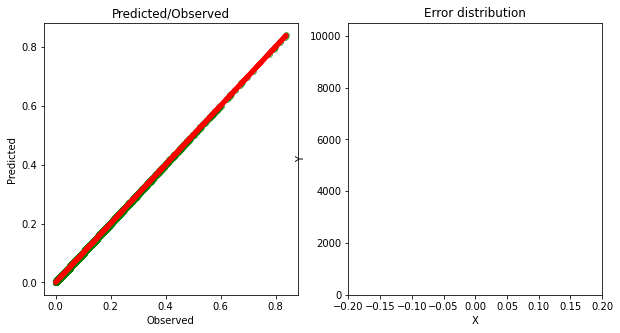

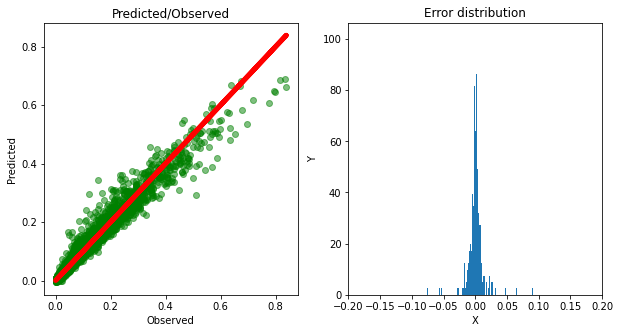

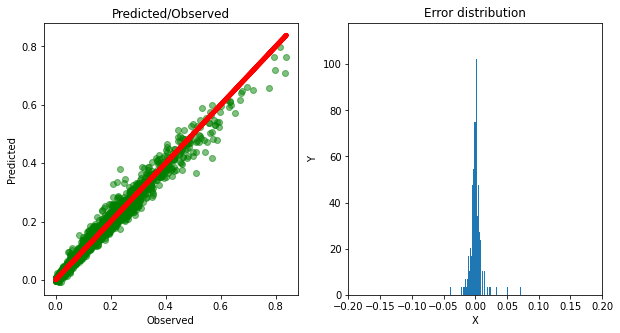

In [ ]:
import gc

for col_name in result.columns:
    y_test = result['actual']
    y_pred = result[col_name]
    print('MODEL :%s\n'%col_name,
          'R^2= %.3f\n'%r2_score(y_test, y_pred))
          #'MSE= %.3f\n'%mean_squared_error(y_test, y_pred) ,
          #'MAE= %.3f\n'%mean_absolute_error(y_test, y_pred))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axs[0].set_title("Predicted/Observed")
    axs[0].set_xlabel("Observed") ; axs[0].set_ylabel("Predicted")
    axs[0].plot(y_test,actual, color="r", lw=5)
    axs[0].scatter(x=y_test, y=y_pred, color="g", marker="o", alpha=0.5)
    

    axs[1].set_title("Error distribution")
    axs[1].set_xlabel("X"); axs[1].set_ylabel("Y")
    k=(y_pred-y_test)
    print(k)
    # axs[1].hist( (y_pred-y_test)/y_test, bins=100, rwidth=5, density=True)
    axs[1].set_xlim([-0.2,0.2])
    axs[1].hist((y_pred-y_test),bins=10000, rwidth=5, density=True)
    #axs[1].plot(y_test,x_data)

    # axs[2].set_title("Error distribution")
    # axs[2].set_xlabel("X"); axs[2].set_ylabel("Y")
    # k=(y_pred-y_test)
    # print(k)
    # # axs[1].hist( (y_pred-y_test)/y_test, bins=100, rwidth=5, density=True)
    # axs[2].set_xlim([-2,2])
    # axs[2].hist((y_pred-y_test),bins=10000, rwidth=5, density=True)
    #axs[1].plot(y_test,x_data)
gc.collect()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from math import sqrt

for col_name in result.columns:
    # result[['actual',col_name]].plot(figsize=(15,10))
    print(col_name)
    print("MSE: ", (mean_squared_error(result.actual, result[col_name])))
    print("MAE: ", (mean_absolute_error(result.actual, result[col_name])))
    print("RMSE:", sqrt(mean_squared_error(result.actual, result[col_name])))
    print("R-squared: ", r2_score(result.actual, result[col_name]))